# Sigma clip and stitch TESS light curves together.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt\

import lightcurvestuff as lcs
import starspot as ss
from starspot import rotation_tools as rt
import re
import glob

Load TESS light curve

In [3]:
fn = glob.glob("/Users/rangus/projects/TESSlightcurves/*fits")

def extract_ticid(fn): 
    numbers = re.findall(r'\d+', fn)
    return int(numbers[2]), int(numbers[1])

ticid, sector = extract_ticid(fn[0])
path = "/Users/rangus/projects/TESSlightcurves/"
str_ticid = str(int(ticid)).zfill(16)
tfile = "tess?????????????-s????-{}-????-s_lc.fits".format(str_ticid)

ticpath = os.path.join(path, tfile)
fnames = sorted(glob.glob(ticpath))[:3]

sectors = []
for f in fnames:
    _, sector = extract_ticid(f)
    sectors.append(sector)
    
time, flux, flux_err = lcs.tools.load_and_split_TESS(fnames)
nsectors = len(flux)
print(sectors, nsectors)

[1, 2, 3] 3


Sigma clip each sector individually.

In [4]:
from tqdm import trange

def sigma_clip_TESS_sector(x, y, yerr):
    x, y, yerr = np.array(x), np.array(y), np.array(yerr)
    
    # Initial removal of extreme outliers.
    m = rt.sigma_clip(y, nsigma=7)
    x, y, yerr = x[m], y[m], yerr[m]

    # Remove outliers using Sav-Gol filter
    smooth, mask = rt.filter_sigma_clip(x, y)
    resids = y - smooth
    stdev = np.std(resids)
    return x[mask], y[mask], yerr[mask], stdev


x, y, yerr, std = [], [], [], []
for i in trange(len(time)):
    t, f, ferr, stdev = sigma_clip_TESS_sector(time[i], flux[i], flux_err[i])
    x.append(t)
    y.append(f)
    yerr.append(ferr)
    std.append(stdev)
    
print(std)
print(np.median(yerr[0]))

  0%|          | 0/3 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

[10.285658711398188, 9.701047886399556, 9.227426721353648]
10.896579


3


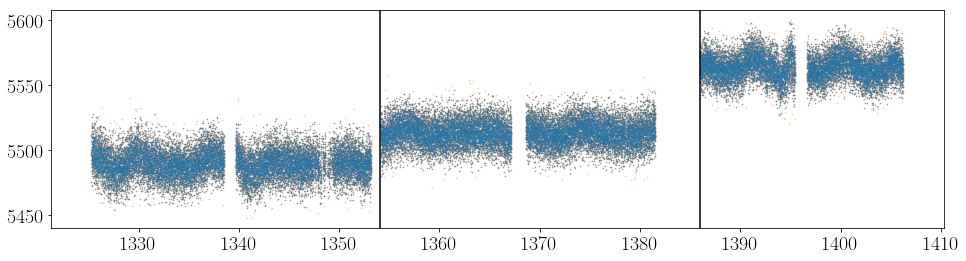

In [5]:
plt.figure(figsize=(16, 4))

start_times, stop_times = [], []
for i in range(len(time)):
    plt.plot(time[i], flux[i], "C1.", ms=1, alpha=.5)
    plt.plot(x[i], y[i], "C0.", ms=1, alpha=.5)
    start_times.append(min(time[i]))
    stop_times.append(max(flux[i]))
print(len(y))
    
gaps = start_times[1:]
for i in range(len(gaps)):
    plt.axvline(gaps[i], color="k")

Format light curve

<ErrorbarContainer object of 3 artists>

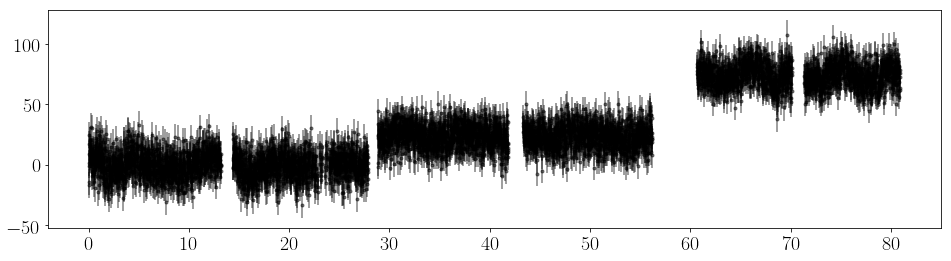

In [6]:
med = np.median(y[0])
y -= med

# Meds
meds = []
for i in range(len(y)):
    meds.append(np.median(y[i]))
    

# Turn into arrays
t = np.array([i for j in x for i in j])
y = np.array([i for j in y for i in j])
yerr = np.array([i for j in yerr for i in j])

# Remove NaNs
m = np.isfinite(t) * np.isfinite(y) * np.isfinite(yerr)
t, y, yerr = t[m], y[m], yerr[m]

# Subsample
subsample = 10
t, y, yerr = t[::subsample], y[::subsample], yerr[::subsample]

# Sort by time
inds = np.argsort(t)
t, y, yerr = t[inds], y[inds], yerr[inds]
gaps -= t[0]
t -= t[0]

# Convert to float64
y64, yerr64 = [np.zeros(len(y), dtype="float64") for i in range(2)]
for i in range(len(y)):
    y64[i] = np.float64(y[i])
    yerr64[i] = np.float64(yerr[i])
y, yerr = y64, yerr64

plt.figure(figsize=(16, 4))
plt.errorbar(t, y, yerr=yerr, fmt="k.", alpha=.5)

28.814460684227925 60.65393815282118


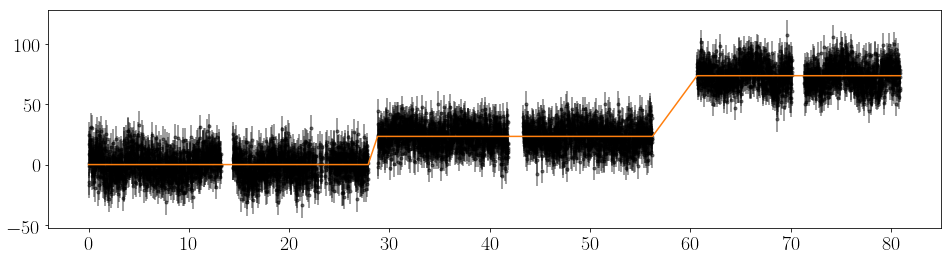

In [7]:
gap_time1, gap_time2 = gaps
print(gap_time1, gap_time2)

plt.figure(figsize=(16, 4))
plt.errorbar(t, y, yerr=yerr, fmt="k.", alpha=.5)

from starspot.stitch import step_model

# # The step model
# def step_model(t, gap_times, steps):
#     mu = np.zeros(len(t))
#     for i in range(len(gap_times)-1):
#         mu += (t > gap_times[i]) * (t < gap_times[i+1]) * steps[i]
#     mu += (t > gap_times[1]) * steps[1]
#     return mu

mu = step_model(t, gaps, meds[1:])
plt.plot(t, mu, "C1", zorder=10)

Find the offsets

In [8]:
# import pymc3 as pm
# import theano.tensor as tt
# from exoplanet.gp import terms, GP
# import exoplanet as xo

# with pm.Model() as model:

#     # Parameters
#     logsigma = pm.Normal("logsigma", mu=0.0, sd=15.0)
#     logrho = pm.Normal("logrho", mu=0.0, sd=5.0)
#     step1 = pm.Normal("step1", mu=meds[1], sd=2.0)
#     step2 = pm.Normal("step2", mu=meds[2], sd=2.0)
    
#     # The step model
#     mu1 = (t > gap_time1) * (t < gap_time2) * step1
#     mu2 = (t > gap_time2) * step2
#     mu = mu1 + mu2
    
#     # The likelihood function assuming known Gaussian uncertainty
#     pm.Normal("obs", mu=mu, sd=yerr, observed=y)

#     # Set up the kernel an GP
#     kernel = terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
#     gp = GP(kernel, t, yerr ** 2)

#     # Add a custom "potential" (log probability function) with the GP likelihood
#     pm.Potential("gp", gp.log_likelihood(y))

In [9]:
# with model:
#     map_soln = xo.optimize(start=model.test_point)

In [17]:
# ms1 = (t > gap_time1) * (t < gap_time2) 
# ms2 = t > gap_time2

# corrected_y = y*1
# corrected_y[ms1] -= map_soln["step1"]
# corrected_y[ms2] -= map_soln["step2"]

import starspot.stitch as sps

gap_times, steps = gaps, meds[1:]
print(len(gap_times), len(steps))
star = sps.StitchModel(t, y, yerr, gap_times, steps, 2.0)
star.model_offsets()
map_soln = star.find_optimum()

step1 = map_soln["step1"]
step2 = map_soln["step2"]
# step3 = map_soln["step3"]

2 2
success: False
initial logp: -53879.4249954133
final logp: -37160.4081336105


In [19]:
# The step model
best_fit_mu = step_model(t, gap_times, steps)
corrected_y = y - best_fit_mu

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.errorbar(t, y, yerr=yerr, fmt=".", alpha=.5)
plt.errorbar(t, corrected_y-70, yerr=yerr, fmt="k.", alpha=.5)

true_t = np.linspace(0, max(t), 500)
mu, var = star.evaluate_model(t)

# with model:
#     mu, var = xo.eval_in_model(gp.predict(true_t, return_var=True), map_soln)
    
# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.3, zorder=10)
art.set_edgecolor("none")
plt.plot(true_t, mu, color="C1", lw=2, label="prediction", zorder=10) 

# mu1 = (t > gap_time1) * (t < gap_time2) * map_soln["step1"]
# mu2 = (t > gap_time2) * map_soln["step2"]
# mu3 = mu1 + mu2
# plt.plot(t, mu3, "C2", zorder=10)

# plt.subplot(2, 1, 2)
# with model:
#     mu, var = xo.eval_in_model(gp.predict(t, return_var=True), map_soln)
# plt.errorbar(t, y-mu, yerr=yerr, fmt="k.")
# plt.axhline(0, zorder=10)

2485


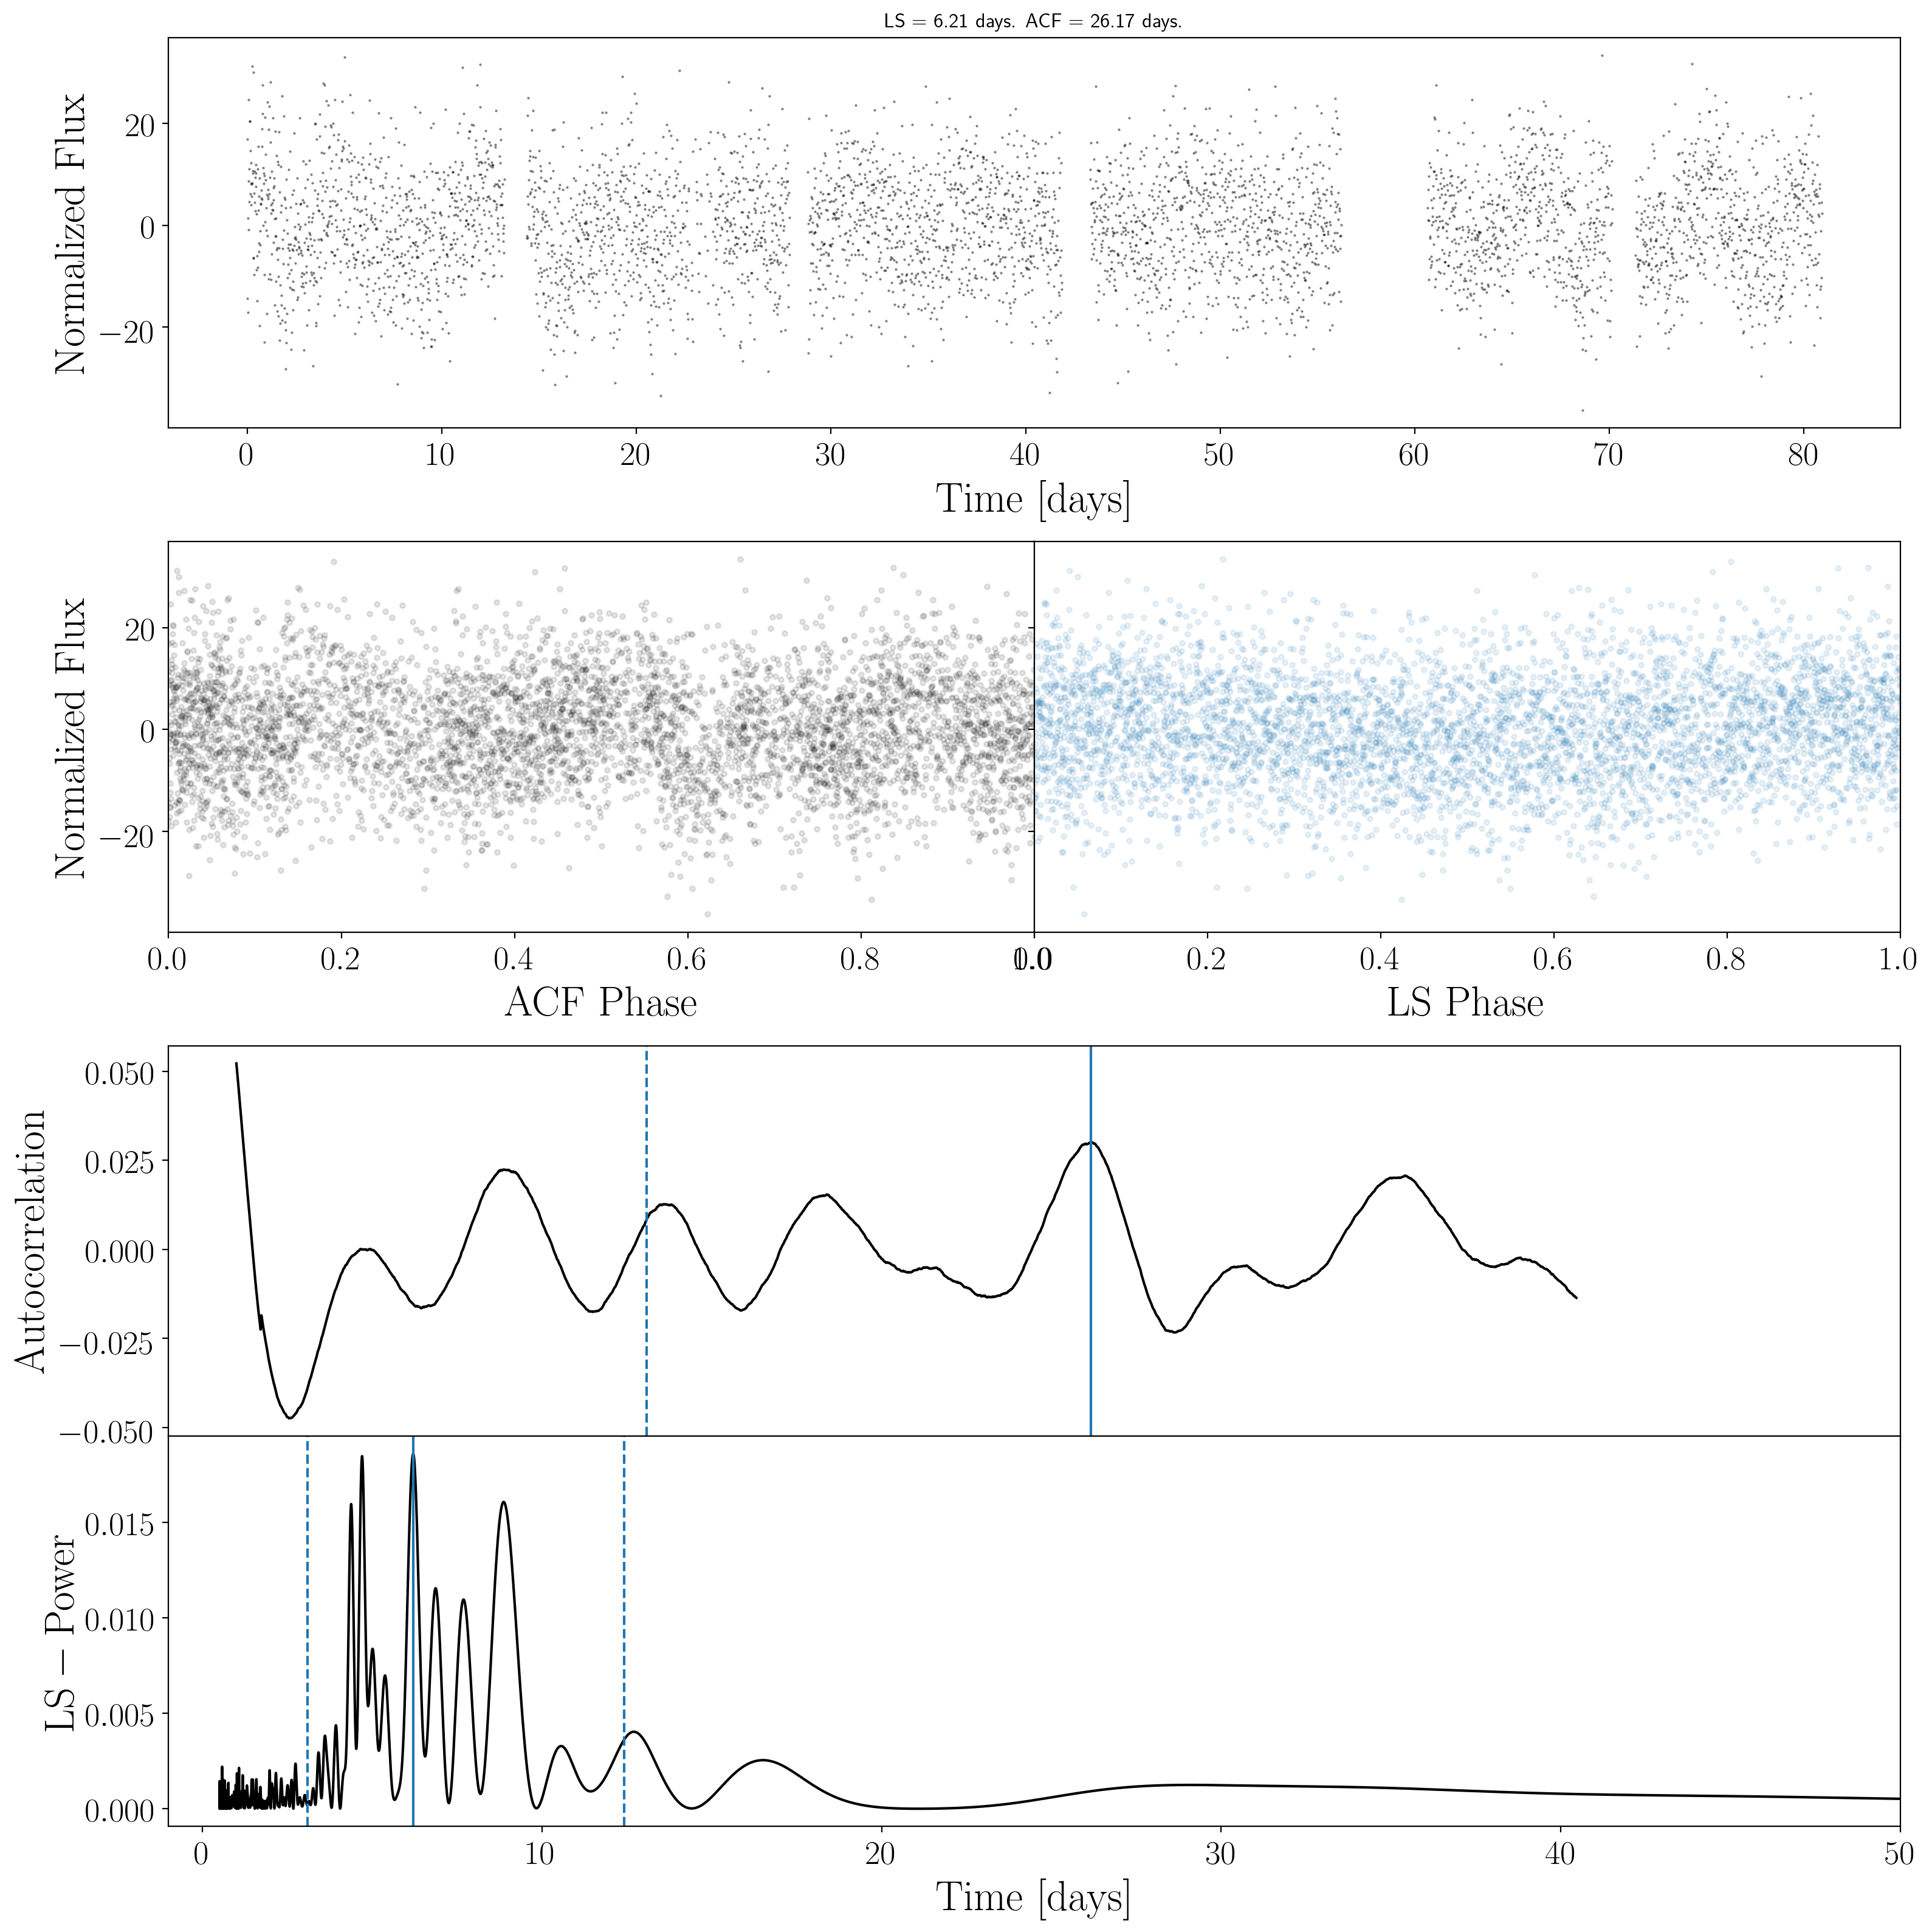

In [26]:
rotate = ss.RotationModel(t, corrected_y, yerr)
ls_period = rotate.ls_rotation()
acf_period = rotate.acf_rotation(interval=0.00138889, cutoff=1, window_length=int(len(t)/2)+1, polyorder=3)
fig = rotate.big_plot(methods=["acf", "ls"], xlim=(-1, 50));